# Time Series Forecasting - 
**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`


In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

In [3]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-data'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

viz_limit = 12

packages:

In [4]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

clients:

In [5]:
bq = bigquery.Client(project = PROJECT_ID)

### Create BigQuery Dataset
Create a BigQuery Dataset within this project 

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us'  
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'applied_forecasting'

In [7]:
ds.full_dataset_id

'vertexaiproject-454121:applied_forecasting'

List BigQuery datasets in the project:

In [8]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
dataset_name
fraud


### Review Source Data
Stored in BigQuery Public Datasets

In [9]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_trips`
    LIMIT 5
"""
bq.query(query).to_dataframe()

tripduration                 starttime                  stoptime  \
0           133 2016-06-14 14:48:17+00:00 2016-06-14 14:50:31+00:00   
1          1620 2016-08-26 10:04:09+00:00 2016-08-26 10:31:09+00:00   
2           134 2014-03-13 18:08:00+00:00 2014-03-13 18:10:14+00:00   
3           179 2016-04-02 17:24:11+00:00 2016-04-02 17:27:11+00:00   
4           720 2014-08-04 11:28:18+00:00 2014-08-04 11:40:18+00:00   

   start_station_id start_station_name  start_station_latitude  \
0               520    W 52 St & 5 Ave               40.759923   
1               520    W 52 St & 5 Ave               40.759923   
2               520    W 52 St & 5 Ave               40.759923   
3               520    W 52 St & 5 Ave               40.759923   
4               520    W 52 St & 5 Ave               40.759923   

   start_station_longitude  end_station_id end_station_name  \
0               -73.976485             520  W 52 St & 5 Ave   
1               -73.976485             520  W 52 St & 5 Ave   
2               -73.976485             520  W 52 St & 5 Ave   
3               -73.976485             520  W 52 St & 5 Ave   
4               -73.976485             520  W 52 St & 5 Ave   

   end_station_latitude  end_station_longitude  bikeid    usertype  \
0             40.759923             -73.976485   22312  Subscriber   
1             40.759923             -73.976485   16311  Subscriber   
2             40.759923             -73.976485   16536  Subscriber   
3             40.759923             -73.976485   17825  Subscriber   
4             40.759923             -73.976485   21500  Subscriber   

   birth_year  gender  
0        1998    male  
1        1993    male  
2        1966  female  
3        1983    male  
4        1954    male

In [10]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_stations`
    LIMIT 5
"""
bq.query(query).to_dataframe()

station_id                        name short_name   latitude  longitude  \
0        495            W 47 St & 10 Ave    6824.07  40.762699 -73.993012   
1       3171     Amsterdam Ave & W 82 St    7360.10  40.785247 -73.976673   
2       3603              31 Ave & 30 St    6857.09  40.764700 -73.924031   
3       3733          Avenue C & E 18 St    5769.04  40.730563 -73.973984   
4       3792  Columbus Dr at Exchange Pl      JC106  40.716870 -74.032810   

   region_id   rental_methods  capacity  eightd_has_key_dispenser  \
0         71  KEY, CREDITCARD         0                     False   
1         71  KEY, CREDITCARD         0                     False   
2         71  KEY, CREDITCARD         0                     False   
3         71  KEY, CREDITCARD         0                     False   
4         70  KEY, CREDITCARD         0                     False   

   num_bikes_available  num_bikes_disabled  num_docks_available  \
0                    0                   0                    0   
1                    0                   0                    0   
2                    0                   0                    0   
3                    0                   0                    0   
4                    0                   0                    0   

   num_docks_disabled  is_installed  is_renting  is_returning  \
0                   0          True        True          True   
1                   0         False       False         False   
2                   0         False       False         False   
3                   0         False       False         False   
4                   0         False       False         False   

   eightd_has_available_keys             last_reported  
0                      False 1970-01-02 00:00:00+00:00  
1                      False 1970-01-02 00:00:00+00:00  
2                      False 1970-01-02 00:00:00+00:00  
3                      False 1970-01-02 00:00:00+00:00  
4                      False 1970-01-02 00:00:00+00:00

Review miss-matches in station names between the two source tables:

You FULL JOIN the two lists STATIONS and TRIPS:

    A FULL JOIN means it keeps all records from both sides:

        If a station name exists in STATIONS but not in TRIPS, it still appears (with NULL for trips).

        If a trip start name exists in TRIPS but not in STATIONS, it still appears (with NULL for stations).

    If a match exists (same name in both), you see it lined up.

In [11]:
query = """
    WITH
        STATIONS AS (
            SELECT distinct name as stations
            FROM `bigquery-public-data.new_york.citibike_stations`
            WHERE name LIKE '%Central Park%'
        ),
        TRIPS AS (
            SELECT distinct start_station_name as trips
            FROM `bigquery-public-data.new_york.citibike_trips`
            WHERE start_station_name LIKE '%Central Park%'   
        )
    SELECT *
    FROM STATIONS a
    FULL JOIN TRIPS b
    on a.stations = b.trips
"""
bq.query(query).to_dataframe()

stations  \
0                    W 106 St & Central Park West   
1   Central Park North & Adam Clayton Powell Blvd   
2                     Central Park West & W 85 St   
3                                            None   
4                     Central Park West & W 76 St   
5                     W 82 St & Central Park West   
6                                            None   
7                        Central Park W & W 97 St   
8                        Central Park W & W 91 St   
9               Grand Army Plaza & Central Park S   
10                         Central Park S & 6 Ave   
11                    Central Park West & W 72 St   
12                                           None   
13                     7 Ave & Central Park South   
14                      Central Park W & W 103 St   
15                    Central Park West & W 68 St   

                                            trips  
0                    W 106 St & Central Park West  
1   Central Park North & Adam Clayton Powell Blvd  
2                     Central Park West & W 85 St  
3                    Central Park West & W 100 St  
4                     Central Park West & W 76 St  
5                     W 82 St & Central Park West  
6                    Central Park West & W 102 St  
7                                            None  
8                                            None  
9               Grand Army Plaza & Central Park S  
10                         Central Park S & 6 Ave  
11                    Central Park West & W 72 St  
12                       Central Park W & W 96 St  
13                                           None  
14                                           None  
15                    Central Park West & W 68 St

### Create a Source Table or View
It is common to need to combine multiple sources together to bring together all the data needed for forecasting.  Here, multiple source tables are referenced to create a combined forecasting source table.

The goal is one row per time point for each time series.  The means aggregating the transaction to a demand signal for each time series and each time point (day, month, quarter, ...).

If all of the data needed for forecasting is already prepared then a statement like this might not be needed.  Adapting this code to your situation it could be a simple as:

```SQL
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
SELECT *
FROM {BQ_SOURCE}
```

In [12]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `bigquery-public-data.new_york.citibike_trips`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `bigquery-public-data.new_york.citibike_stations`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.359

Group by station and date (start_station_name, starttime).

For each station-date:

    Count the number of trips (num_trips).

    Compute the average trip duration (avg_tripduration).

    Compute the percentage of trips by subscribers (pct_subscriber).

    Compute the ratio of male to non-male trips (ratio_gender):

        If there are no non-male trips, SAFE_DIVIDE prevents division by zero.

In [13]:
print(f'Review The Source Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_source&pli=1')

Review The Source Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!4m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_source&pli=1


In [6]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

start_station_name   starttime  num_trips  \
0   Central Park North & Adam Clayton Powell Blvd  2016-09-01         14   
1   Central Park North & Adam Clayton Powell Blvd  2016-09-02        151   
2   Central Park North & Adam Clayton Powell Blvd  2016-09-03        255   
3   Central Park North & Adam Clayton Powell Blvd  2016-09-04        328   
4   Central Park North & Adam Clayton Powell Blvd  2016-09-05        259   
5   Central Park North & Adam Clayton Powell Blvd  2016-09-06         96   
6   Central Park North & Adam Clayton Powell Blvd  2016-09-07        117   
7   Central Park North & Adam Clayton Powell Blvd  2016-09-08        142   
8   Central Park North & Adam Clayton Powell Blvd  2016-09-09        129   
9   Central Park North & Adam Clayton Powell Blvd  2016-09-10        186   
10  Central Park North & Adam Clayton Powell Blvd  2016-09-11        221   
11  Central Park North & Adam Clayton Powell Blvd  2016-09-12        148   

    avg_tripduration  pct_subscriber  ratio_gender  capacity  
0        2601.428571        0.214286      0.272727        36  
1        1700.635762        0.324503      0.336283        36  
2        1902.439216        0.203922      0.214286        36  
3        1858.871951        0.213415      0.228464        36  
4        1721.289575        0.339768      0.328205        36  
5        1468.666667        0.468750      0.655172        36  
6        1722.623932        0.512821      0.581081        36  
7        1677.795775        0.366197      0.339623        36  
8        1693.069767        0.372093      0.343750        36  
9        1659.198925        0.327957      0.398496        36  
10       1610.226244        0.352941      0.339394        36  
11       1804.114865        0.479730      0.465347        36

In [7]:
overview.tail(viz_limit)

start_station_name   starttime  num_trips  avg_tripduration  \
4370  W 82 St & Central Park West  2016-09-19         34        968.676471   
4371  W 82 St & Central Park West  2016-09-20         62        781.258065   
4372  W 82 St & Central Park West  2016-09-21         67        822.761194   
4373  W 82 St & Central Park West  2016-09-22         58        907.603448   
4374  W 82 St & Central Park West  2016-09-23        117        940.495726   
4375  W 82 St & Central Park West  2016-09-24        161       1287.490683   
4376  W 82 St & Central Park West  2016-09-25        143       1604.370629   
4377  W 82 St & Central Park West  2016-09-26        102       1035.117647   
4378  W 82 St & Central Park West  2016-09-27        105        921.800000   
4379  W 82 St & Central Park West  2016-09-28         72        769.097222   
4380  W 82 St & Central Park West  2016-09-29        143       1105.370629   
4381  W 82 St & Central Park West  2016-09-30         42        691.452381   

      pct_subscriber  ratio_gender  capacity  
4370        0.735294      1.266667        45  
4371        0.887097      1.695652        45  
4372        0.850746      1.161290        45  
4373        0.827586      1.900000        45  
4374        0.743590      1.127273        45  
4375        0.664596      1.064103        45  
4376        0.545455      0.662791        45  
4377        0.617647      0.854545        45  
4378        0.819048      1.333333        45  
4379        0.819444      2.130435        45  
4380        0.650350      0.932432        45  
4381        1.000000      2.230769        45

array([[<Axes: title={'center': 'num_trips'}>,
        <Axes: title={'center': 'avg_tripduration'}>],
       [<Axes: title={'center': 'pct_subscriber'}>,
        <Axes: title={'center': 'ratio_gender'}>],
       [<Axes: title={'center': 'capacity'}>, <Axes: >]], dtype=object)

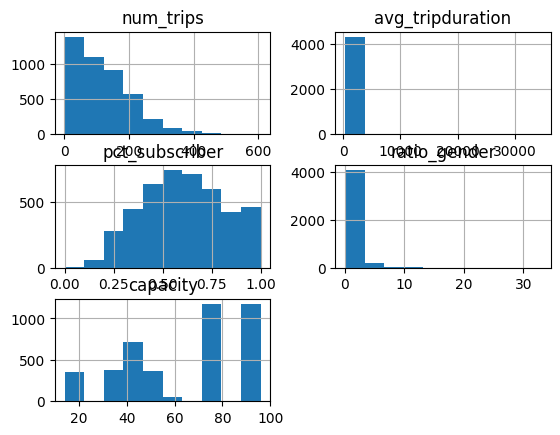

In [8]:
overview.hist()

### Prepare Data for Forecasting

In [11]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Quick Summary of Series with totals and date ranges for each series:

In [15]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

start_station_name  num_trips    FromDate  \
0   Central Park North & Adam Clayton Powell Blvd       4808  2016-09-01   
1                          Central Park S & 6 Ave     172220  2013-07-01   
2                        Central Park W & W 96 St       5905  2016-08-04   
3                    Central Park West & W 100 St       2245  2016-08-08   
4                    Central Park West & W 102 St       2851  2016-08-08   
5                     Central Park West & W 68 St      35192  2015-09-01   
6                     Central Park West & W 72 St      44574  2015-09-01   
7                     Central Park West & W 76 St      27919  2015-09-09   
8                     Central Park West & W 85 St      43895  2015-10-07   
9               Grand Army Plaza & Central Park S     163815  2013-07-01   
10                   W 106 St & Central Park West       4076  2016-08-11   
11                    W 82 St & Central Park West      18216  2015-09-29   

        ToDate  
0   2016-09-30  
1   2016-09-30  
2   2016-09-30  
3   2016-09-30  
4   2016-09-30  
5   2016-09-30  
6   2016-09-30  
7   2016-09-30  
8   2016-09-23  
9   2016-09-30  
10  2016-09-30  
11  2016-09-30

Visualize each series date/time range:

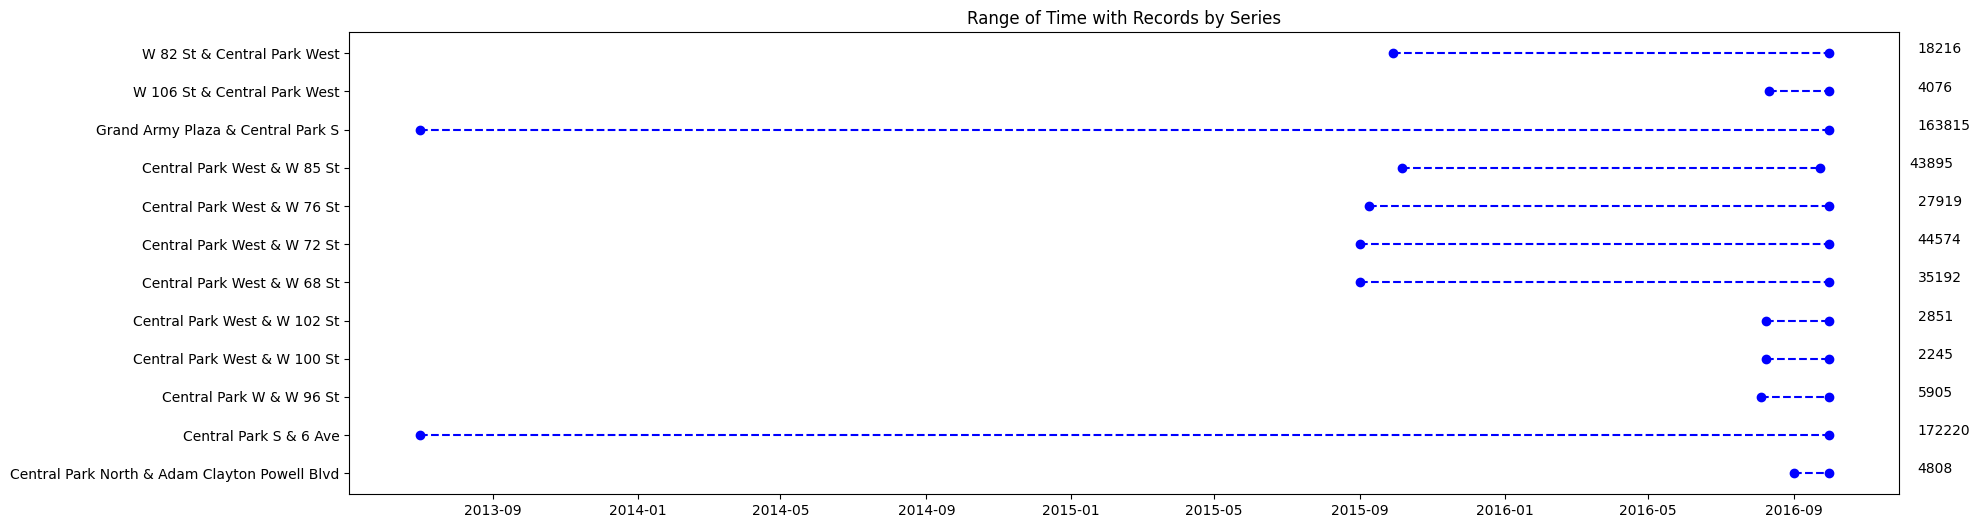

In [16]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

Overlay the dates with data onto the plot to understand any gaps in data for the series:

In [17]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq.query(query).to_dataframe()

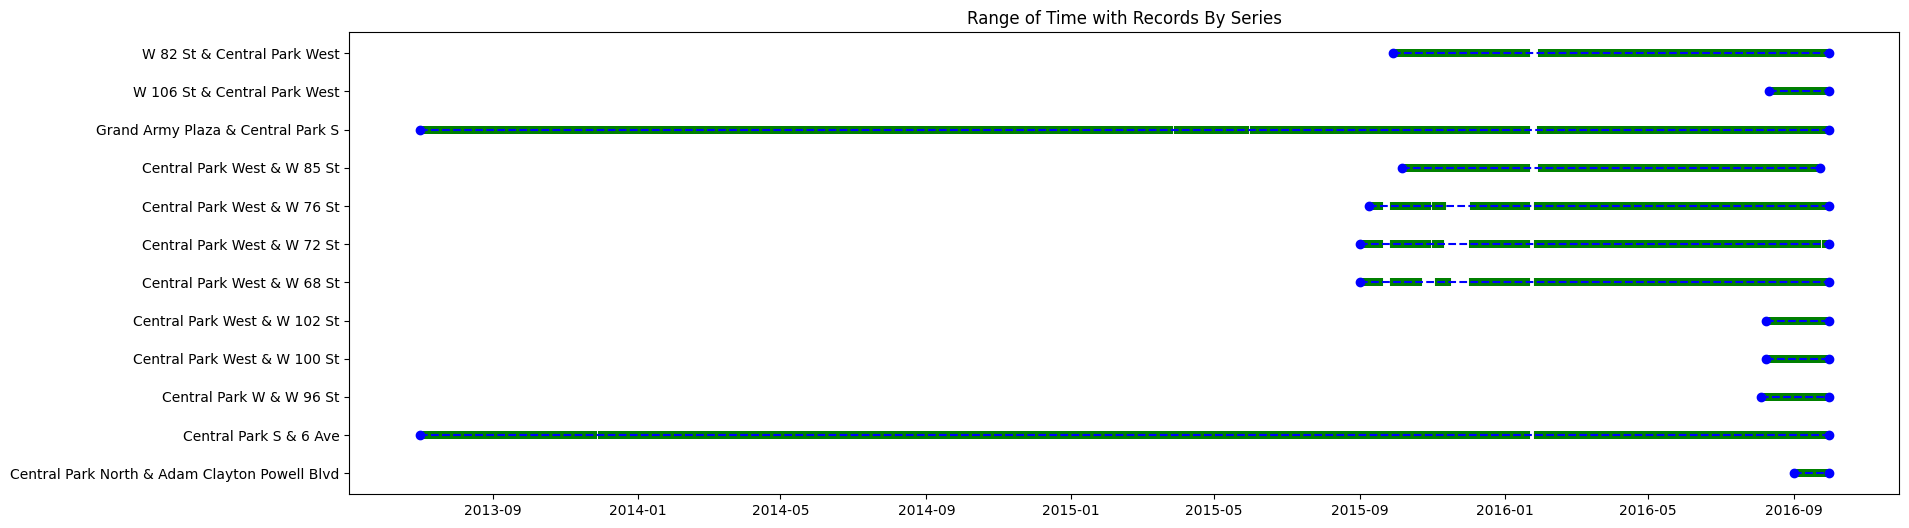

In [18]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows 
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year 
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [19]:
# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

In [20]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH + FORECAST_VALIDATE_LENGTH}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

Visualize each series date/time range with proposed data segments from key dates:

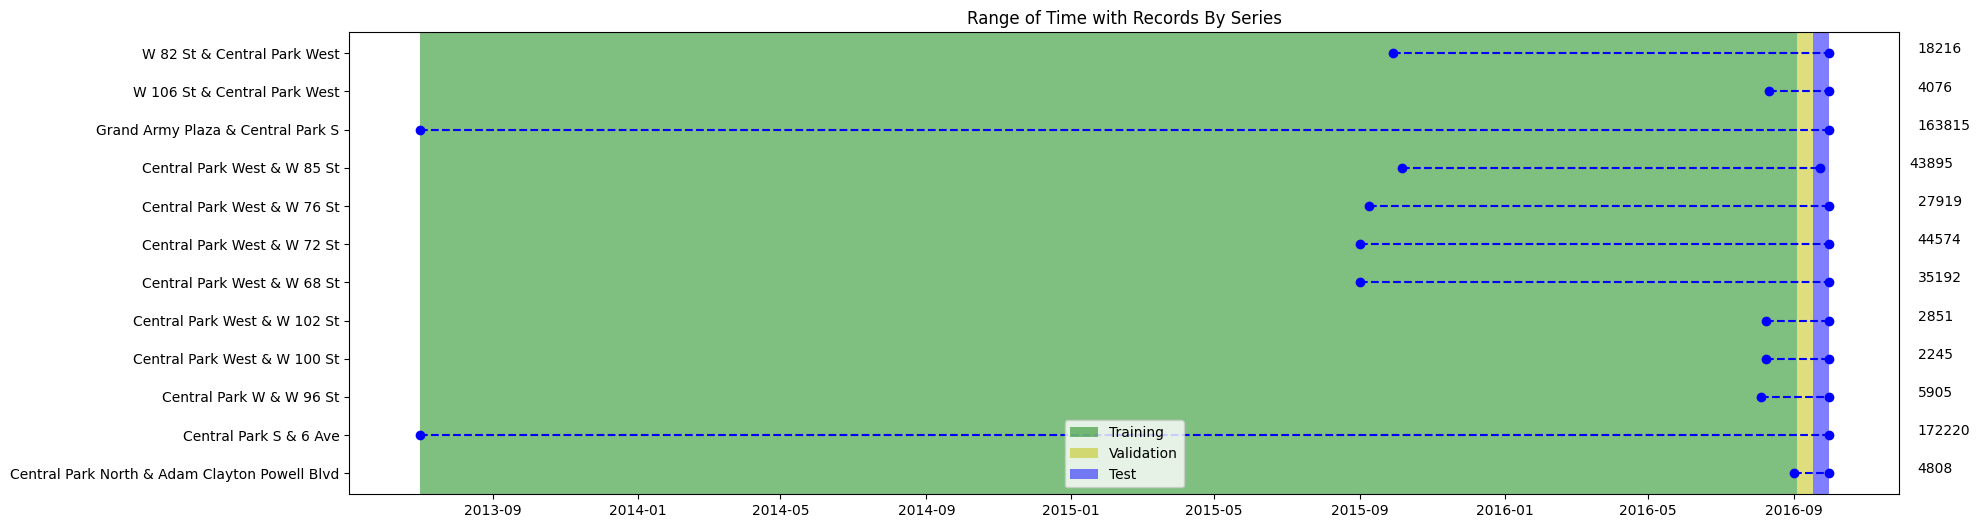

In [21]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting
Put it all together!

In [22]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} {FORECAST_GRANULARITY}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} + {FORECAST_VALIDATE_LENGTH} {FORECAST_GRANULARITY}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS {SPLIT_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.647

In [23]:
print(f'Review The Prepped Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_prepped&pli=1')

Review The Prepped Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!4m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_prepped&pli=1


In [9]:
query = f"""
    SELECT 
        *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
"""
bq.query(query).to_dataframe()

start_station_name   starttime  num_trips  avg_tripduration  \
0          Central Park S & 6 Ave  2013-08-21        151       1837.205298   
1          Central Park S & 6 Ave  2013-10-27        139       2466.568345   
2          Central Park S & 6 Ave  2013-12-07         51       2269.235294   
3          Central Park S & 6 Ave  2013-12-20         38       1455.000000   
4          Central Park S & 6 Ave  2014-02-12          6        588.666667   
...                           ...         ...        ...               ...   
4377  W 82 St & Central Park West  2016-04-10         36       1362.111111   
4378  W 82 St & Central Park West  2016-04-28         34        744.411765   
4379  W 82 St & Central Park West  2016-07-01         78       2200.192308   
4380  W 82 St & Central Park West  2016-08-21         78       1181.192308   
4381  W 82 St & Central Park West  2016-08-25         48        945.291667   

      pct_subscriber  ratio_gender  capacity splits  
0           0.463576      0.424528        73  TRAIN  
1           0.374101      0.323810        73  TRAIN  
2           0.431373      0.593750        73  TRAIN  
3           0.605263      1.235294        73  TRAIN  
4           0.833333      5.000000        73  TRAIN  
...              ...           ...       ...    ...  
4377        0.694444      1.000000        45  TRAIN  
4378        0.882353      1.615385        45  TRAIN  
4379        0.602564      0.857143        45  TRAIN  
4380        0.474359      0.591837        45  TRAIN  
4381        0.812500      1.086957        45  TRAIN  

[4382 rows x 8 columns]

## Review Forecasting Data

In [24]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF({SPLIT_COLUMN} = 'TRAIN') as TRAIN,
        COUNTIF({SPLIT_COLUMN} = 'VALIDATE') as VALIDATE,
        COUNTIF({SPLIT_COLUMN} = 'TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

start_station_name  TRAIN  VALIDATE  TEST  \
0   Central Park North & Adam Clayton Powell Blvd      2        14    14   
1                          Central Park S & 6 Ave   1149        14    14   
2                        Central Park W & W 96 St     30        14    14   
3                    Central Park West & W 100 St     26        14    14   
4                    Central Park West & W 102 St     26        14    14   
5                     Central Park West & W 68 St    331        14    14   
6                     Central Park West & W 72 St    334        14    13   
7                     Central Park West & W 76 St    327        14    14   
8                     Central Park West & W 85 St    324        14     7   
9               Grand Army Plaza & Central Park S   1152        14    13   
10                   W 106 St & Central Park West     23        14    14   
11                    W 82 St & Central Park West    331        14    14   

    num_trips  
0        4808  
1      172220  
2        5905  
3        2245  
4        2851  
5       35192  
6       44574  
7       27919  
8       43895  
9      163815  
10       4076  
11      18216

Totals by data split:

In [25]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: Int64

Overall total:

In [26]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

np.int64(4382)

Visualize days of data available for forecasting at each series:

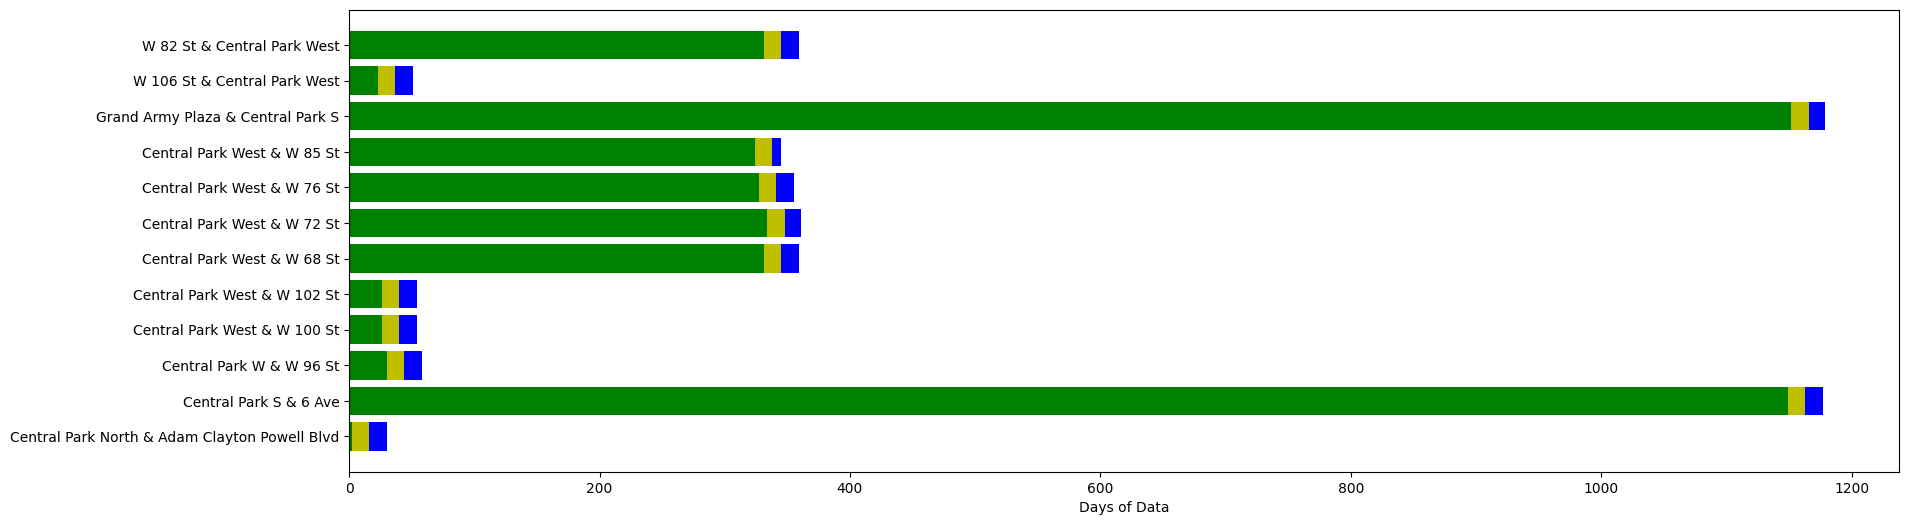

In [27]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [28]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

## Validation Check: Duplicate Dates in Series?
Are there any series with data for duplicate dates?

In [29]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

Empty DataFrame
Columns: [start_station_name, starttime, records]
Index: []

## Time Series Review

In [12]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()
rawSeries.head()

start_station_name   starttime  num_trips  \
0  Central Park North & Adam Clayton Powell Blvd  2016-09-01         14   
1  Central Park North & Adam Clayton Powell Blvd  2016-09-02        151   
2  Central Park North & Adam Clayton Powell Blvd  2016-09-03        255   
3  Central Park North & Adam Clayton Powell Blvd  2016-09-04        328   
4  Central Park North & Adam Clayton Powell Blvd  2016-09-05        259   

     splits  avg_tripduration  pct_subscriber  ratio_gender  capacity  
0     TRAIN       2601.428571        0.214286      0.272727        36  
1     TRAIN       1700.635762        0.324503      0.336283        36  
2  VALIDATE       1902.439216        0.203922      0.214286        36  
3  VALIDATE       1858.871951        0.213415      0.228464        36  
4  VALIDATE       1721.289575        0.339768      0.328205        36

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

In [31]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

**Example Visual**

The visual above is dynamic with selectable ranges for the timeframe and a drop down to select individual time series.  Load this notebook in a view like Jupyter or VSCode to interact with it.  A static version is displayed below as an example:

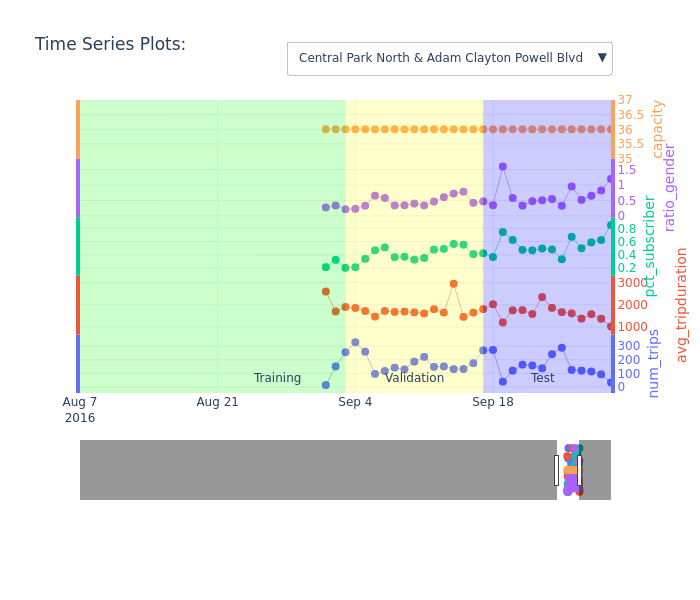

In [32]:
fig.show('png')

# forecasting method: model_type = 'ARIMA_PLUS_XREG' = Use ARIMA with external features (XREG)

In [33]:
EXPERIMENT = 'bqml-arimaplusxreg'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [34]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE


In [35]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates



start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

In [36]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()


In [37]:
chosen_station = 'Central Park S & 6 Ave'
rawSeries = rawSeries[rawSeries[SERIES_COLUMN]==chosen_station]

In [38]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)
    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()


A Snapshot of the interactive plot:


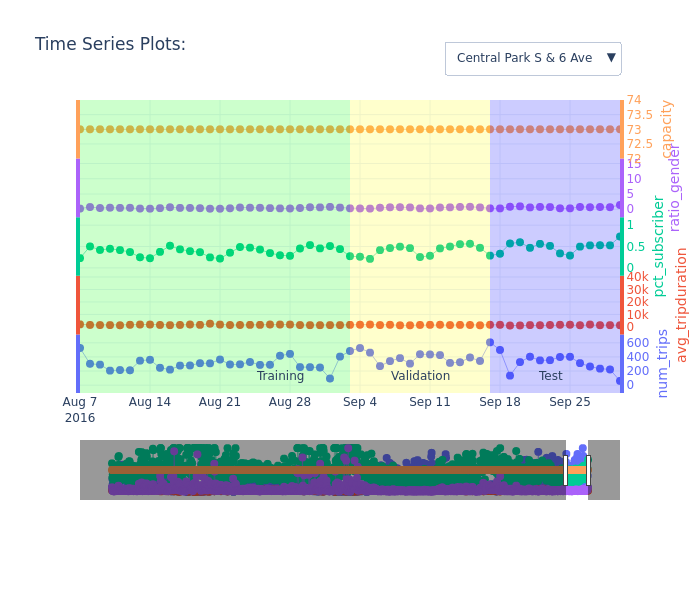

In [39]:
print('A Snapshot of the interactive plot:')
fig.show('png')


In [40]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       #time_series_id_col = '{SERIES_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = '{chosen_station}'
"""
print(query)



    CREATE OR REPLACE MODEL `vertexaiproject-454121.applied_forecasting.forecasting-data_prepped_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       #time_series_id_col = 'start_station_name',
       data_frequency = 'DAILY',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = 14 + 14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `vertexaiproject-454121.applied_forecasting.forecasting-data_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [41]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

print(f'Review The Model in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_arimaplusxreg&pli=1')


DONE 19.457
Review The Model in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!5m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_prepped_arimaplusxreg&pli=1


## Model results:

In [42]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients


ar_coefficients                                    ma_coefficients  \
0              []                                                 []   
1              []                                                 []   
2              []                                                 []   
3              []                                                 []   
4              []                                                 []   
5              []  [-0.6885407234910769, -0.40916916413577, 0.703...   

   intercept_or_drift   processed_input       weight category_weights  
0                 NaN  avg_tripduration    -0.001514               []  
1                 NaN    pct_subscriber  -302.167414               []  
2                 NaN      ratio_gender     2.385852               []  
3                 NaN          capacity    25.285775               []  
4                 NaN     __INTERCEPT__ -1724.433226               []  
5            0.087799              None          NaN               []

In [43]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()


input      min           max         mean       median  \
0         num_trips    1.000    555.000000   144.153912   128.000000   
1         starttime      NaN           NaN          NaN          NaN   
2  avg_tripduration  336.625  34597.615385  1918.560216  1832.565517   
3    pct_subscriber    0.000      1.000000     0.497785     0.466667   
4      ratio_gender    0.000     14.000000     0.908012     0.567568   

        stddev  category_count  null_count  dimension  
0   112.409702            <NA>           0       <NA>  
1          NaN            1163           0       <NA>  
2  1334.905339            <NA>           0       <NA>  
3     0.214707            <NA>           0       <NA>  
4     1.329083            <NA>          26       <NA>

In [44]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

training_run  iteration  duration_ms
0             0          0         1585

## evaluating your trained ARIMA+XREG model on the TEST data for the chosen station.


Forecast Metrics

Reference for ML.EVALUATE for model_type = 'ARIMA_PLUS_XREG'

The metrics returned depend on if input (test) data is provided and if perform_aggregation is True or False. If False then metrics per timestamp are provide, and if True then metrics per time_series_id_col are provided.

In [45]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics


mean_absolute_error  mean_squared_error  root_mean_squared_error  \
0              83.9561         12677.33045               112.593652   

   mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                       36.437686                                  31.24371

### ML.ARIMA_EVALUATE gives you detailed diagnostics about the ARIMA model BigQuery ML fitted.

A model metrics table: ARIMA terms:

    p = how many autoregressive terms
    d = how many nonseasonal differences needed for stationarity
    q = number of lagged forecast errors (moving average part)


In [46]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  log_likelihood  \
0               0               1               5       True    -5781.139502   

            AIC     variance  seasonal_periods  has_holiday_effect  \
0  11576.279005  1109.243709  [WEEKLY, YEARLY]                True   

   has_spikes_and_dips  has_step_changes error_message  
0                 True             False

A list of holidays being modeled and have detected holiday effects:

    region, these were specified in the CREATE MODEL statement with parameter holiday_region
    holiday_name is the name of the holiday with detect effect
    primary_date is the calender date of the holiday
    preholiday_days and postholiday_days are the integer window around the holiday taken into account during modeling


In [47]:
query = f"""
    SELECT *
    FROM ML.HOLIDAY_INFO(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
holiday_info = bq.query(query).to_dataframe()
holiday_info


region            holiday_name primary_date  preholiday_days  \
0     GLOBAL  AllSaintsDay-Halloween   2000-10-31                1   
1     GLOBAL  AllSaintsDay-Halloween   2001-10-31                1   
2     GLOBAL  AllSaintsDay-Halloween   2002-10-31                1   
3     GLOBAL  AllSaintsDay-Halloween   2003-10-31                1   
4     GLOBAL  AllSaintsDay-Halloween   2004-10-31                1   
...      ...                     ...          ...              ...   
1901      US              VeteranDay   2026-11-11                1   
1902      US              VeteranDay   2027-11-11                1   
1903      US              VeteranDay   2028-11-11                1   
1904      US              VeteranDay   2029-11-11                1   
1905      US              VeteranDay   2030-11-11                1   

      postholiday_days  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
1901                 1  
1902                 1  
1903                 1  
1904                 1  
1905                 1  

[1906 rows x 5 columns]

# Forecast Time Series

ML.FORECAST predicts future values using your trained model.

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level. The default horizon is 3 so this parameter may need to be set to the size used at training.

You specify:

    horizon → how many steps into the future (ex: 14 days).

    confidence_level → how sure you want the prediction intervals to be (95% = pretty standard).

You also pass covariates (XREGs) for the prediction period.

In [48]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

forecast_timestamp  forecast_value  standard_error  \
0  2016-09-17 00:00:00+00:00      359.108875       33.305317   
1  2016-09-18 00:00:00+00:00      492.313739       34.883357   
2  2016-09-19 00:00:00+00:00      333.527815       35.034823   
3  2016-09-20 00:00:00+00:00      166.268431       40.421154   
4  2016-09-21 00:00:00+00:00      250.371314       48.236057   
5  2016-09-22 00:00:00+00:00      262.645345       48.280443   
6  2016-09-23 00:00:00+00:00      280.352952       48.324789   
7  2016-09-24 00:00:00+00:00      326.100022       48.369094   
8  2016-09-25 00:00:00+00:00      383.062154       48.413358   
9  2016-09-26 00:00:00+00:00      306.364521       48.457582   
10 2016-09-27 00:00:00+00:00      226.331274       48.501765   
11 2016-09-28 00:00:00+00:00      251.904286       48.545908   
12 2016-09-29 00:00:00+00:00      209.442504       48.590012   
13 2016-09-30 00:00:00+00:00      141.314434       48.634075   

    confidence_level  prediction_interval_lower_bound  \
0               0.95                       293.948418   
1               0.95                       424.065912   
2               0.95                       264.983652   
3               0.95                        87.186138   
4               0.95                       155.999490   
5               0.95                       168.186681   
6               0.95                       185.807528   
7               0.95                       231.467918   
8               0.95                       288.343448   
9               0.95                       211.559293   
10              0.95                       131.439603   
11              0.95                       156.926250   
12              0.95                       114.378183   
13              0.95                        46.163905   

    prediction_interval_upper_bound  
0                        424.269332  
1                        560.561566  
2                        402.071977  
3                        245.350725  
4                        344.743138  
5                        357.104009  
6                        374.898376  
7                        420.732127  
8                        477.780859  
9                        401.169749  
10                       321.222945  
11                       346.882321  
12                       304.506826  
13                       236.464963

Forecast + Explanations for Time Series

ML.EXPLAIN_FORECAST: enhanced forecasting function that also includes explaination information.

In addition to forecast and the accompanying prediction intervals, this also includes the actual value and information for trend, seasonality, holiday effects, spikes and dips, step changes, and attributions for the external regressors.

In [49]:
query = f"""
    SELECT '{chosen_station}' as {SERIES_COLUMN}, *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_HORIZON_LENGTH + FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SERIES_COLUMN} = '{chosen_station}'
        )
        )
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain.tail()


start_station_name     time_series_timestamp time_series_type  \
1197  Central Park S & 6 Ave 2016-10-10 00:00:00+00:00         forecast   
1198  Central Park S & 6 Ave 2016-10-11 00:00:00+00:00         forecast   
1199  Central Park S & 6 Ave 2016-10-12 00:00:00+00:00         forecast   
1200  Central Park S & 6 Ave 2016-10-13 00:00:00+00:00         forecast   
1201  Central Park S & 6 Ave 2016-10-14 00:00:00+00:00         forecast   

      time_series_data  time_series_adjusted_data  standard_error  \
1197        342.617766                 342.617766       49.072531   
1198        324.312326                 324.312326       49.116161   
1199        280.494110                 280.494110       49.159752   
1200        233.236731                 233.236731       49.203305   
1201        274.001882                 274.001882       49.246820   

      confidence_level  prediction_interval_lower_bound  \
1197              0.95                       246.609417   
1198              0.95                       228.218616   
1199              0.95                       184.315115   
1200              0.95                       136.972526   
1201              0.95                       177.652543   

      prediction_interval_upper_bound       trend  ...  \
1197                       438.626116  273.152363  ...   
1198                       420.406036  273.240162  ...   
1199                       376.673106  273.327960  ...   
1200                       329.500936  273.415759  ...   
1201                       370.351221  273.503558  ...   

      holiday_effect_Halloween  holiday_effect_MardiGras  \
1197                       0.0                       0.0   
1198                       0.0                       0.0   
1199                       0.0                       0.0   
1200                       0.0                       0.0   
1201                       0.0                       0.0   

      holiday_effect_US_ColumbusDay  holiday_effect_US_ElectionDay  \
1197                            0.0                            0.0   
1198                            0.0                            0.0   
1199                            0.0                            0.0   
1200                            0.0                            0.0   
1201                            0.0                            0.0   

      attribution_avg_tripduration  attribution_pct_subscriber  \
1197                     -2.904546                 -150.414332   
1198                     -2.904546                 -150.414332   
1199                     -2.904546                 -150.414332   
1200                     -2.904546                 -150.414332   
1201                     -2.904546                 -150.414332   

      attribution_ratio_gender  attribution_capacity  \
1197                  2.166382           1845.861568   
1198                  2.166382           1845.861568   
1199                  2.166382           1845.861568   
1200                  2.166382           1845.861568   
1201                  2.166382           1845.861568   

      attribution___INTERCEPT__   starttime  
1197               -1724.433226  2016-10-10  
1198               -1724.433226  2016-10-11  
1199               -1724.433226  2016-10-12  
1200               -1724.433226  2016-10-13  
1201               -1724.433226  2016-10-14  

[5 rows x 71 columns]

In [50]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

/var/tmp/ipykernel_3287/2160216593.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



A Snapshot of the interactive plot:


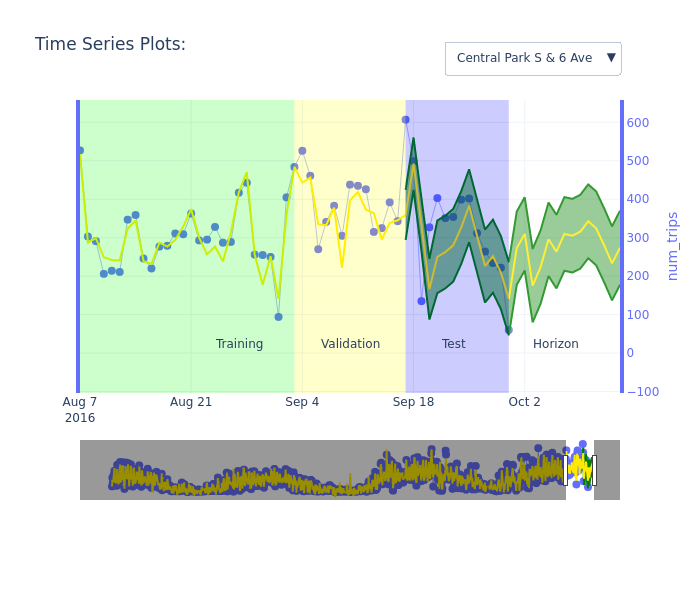

In [51]:
print('A Snapshot of the interactive plot:')
fig.show('png')

### Calculate Metrics

In [52]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE {SPLIT_COLUMN} = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST' AND {SERIES_COLUMN} = '{chosen_station}'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)


start_station_name time_series_type      MAPE      MAE      pMAE  \
0  Central Park S & 6 Ave         forecast  0.364377  83.9561  0.257252   

           MSE        RMSE     pRMSE  
0  12677.33045  112.593652  0.345001

### Overall Metrics

In [53]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

time_series_type      MAPE      MAE      pMAE          MSE        RMSE  \
0         forecast  0.364377  83.9561  0.257252  12677.33045  112.593652   

      pRMSE  
0  0.345001

In [54]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg')
#bq.delete_model(model)

# Regression models for forecasting:

In [3]:
REGION = 'us-central1'
EXPERIMENT = 'bqml-regression'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

packages:

In [4]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import sleep

clients:

In [5]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

Retrieve Key Dates for splits:

In [6]:
query = f"""
    WITH
        SPLIT AS (
            SELECT {SPLIT_COLUMN}, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

Retrieve raw data:

In [7]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

---
## Example 1: Linear Regression

- Prediction - What is demand today based on
    - Covariates
    - Using Time Features: Week, Month, Year, Day, ...

Regression methods don't know about time/date based data types.  To get started, lets first decompose the `TIME_COLUMN` into parts like year, month, day, day of week and model with a linear regression to find the optimal weights of these components.

In [10]:
EX1_CTE = f"""
WITH EX1_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)},
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [11]:
BQ_MODEL = f"{BQ_TABLE}_regression_ex1"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX1_CTE}
    SELECT
        * EXCEPT({SPLIT_COLUMN}),
        CASE
            WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX1_CTE
    WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 14.316


In [12]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_regression_ex1


In [13]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input        weight  \
0   start_station_name           NaN   
1     avg_tripduration     -0.000582   
2       pct_subscriber   -213.188933   
3         ratio_gender     -1.091443   
4             capacity     -1.612786   
5                 Year     24.909874   
6                Month    310.285385   
7         Day_of_Month     10.161219   
8          Day_of_Year    -10.020749   
9          Day_of_Week     -0.609004   
10             Weekend      1.685334   
11       __INTERCEPT__ -50680.737789   

                                     category_weights  
0   [{'category': 'Central Park North & Adam Clayt...  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9                                                  []  
10                                                 []  
11                                                 []

In [14]:
weights['category_weights'].iloc[0]

array([{'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': 317.64037373673693},
       {'category': 'Central Park West & W 100 St', 'weight': 375.91667401729654},
       {'category': 'Central Park West & W 102 St', 'weight': 406.52133753302024},
       {'category': 'Central Park West & W 76 St', 'weight': 343.27745421769794},
       {'category': 'Central Park W & W 96 St', 'weight': 442.57090486546235},
       {'category': 'Central Park S & 6 Ave', 'weight': 517.2752624126209},
       {'category': 'W 82 St & Central Park West', 'weight': 413.48945814205666},
       {'category': 'W 106 St & Central Park West', 'weight': 408.5201017097512},
       {'category': 'Grand Army Plaza & Central Park S', 'weight': 586.5418653015313},
       {'category': 'Central Park West & W 85 St', 'weight': 451.2269575607781},
       {'category': 'Central Park West & W 72 St', 'weight': 454.53510486383044},
       {'category': 'Central Park West & W 68 St', 'weight': 436.7421670723383}],
 

In [15]:
query = f"""
{EX1_CTE}
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'TRAIN'))
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0     TRAIN            45.374309         3732.591382                0.537276   
1  VALIDATE            59.484503         6872.123524                0.479323   
2      TEST            57.448783         6548.842378                0.726357   

   median_absolute_error  r2_score  explained_variance  
0              34.489672  0.504250            0.504250  
1              40.664097  0.393723            0.626341  
2              39.449742  0.357435            0.622654

### Custom Evaluation Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```

In [16]:
query = f"""
{EX1_CTE},
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`, (
                SELECT *
                FROM EX1_CTE
                WHERE {SPLIT_COLUMN} = 'TEST'
            ))
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex1 = bq.query(query = query).to_dataframe()
customMetrics_ex1

start_station_name      MAPE         MAE  \
0   Central Park North & Adam Clayton Powell Blvd  0.937319  127.340635   
1                          Central Park S & 6 Ave  0.485674  158.592184   
2                        Central Park W & W 96 St  0.396896   35.582368   
3                    Central Park West & W 100 St  0.890347   28.196119   
4                    Central Park West & W 102 St  0.762395   32.787437   
5                     Central Park West & W 68 St  0.344680   57.045808   
6                     Central Park West & W 72 St  0.299342   54.938694   
7                     Central Park West & W 76 St  0.354958   35.710059   
8                     Central Park West & W 85 St  0.416622   31.290689   
9               Grand Army Plaza & Central Park S  0.354344   51.661987   
10                   W 106 St & Central Park West  0.461466   30.784199   
11                    W 82 St & Central Park West  0.383930   31.783540   

        pMAE           MSE        RMSE     pRMSE  
0   0.820418  19155.889904  138.404804  0.891701  
1   0.485947  34053.363213  184.535534  0.565440  
2   0.355570   1644.105371   40.547569  0.405186  
3   0.711253   1184.708864   34.419600  0.868242  
4   0.647425   1392.820513   37.320511  0.736935  
5   0.376540   4625.396357   68.010267  0.448913  
6   0.310523   4181.733784   64.666327  0.365505  
7   0.326119   1548.448125   39.350326  0.359364  
8   0.248903   1481.648610   38.492189  0.306188  
9   0.237568   3667.488515   60.559793  0.278485  
10  0.460940   1308.075602   36.167328  0.541543  
11  0.344404   1433.942616   37.867435  0.410328

In [17]:
query = f"""
{EX1_CTE},
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`, (
                SELECT *
                FROM EX1_CTE
                WHERE {SPLIT_COLUMN} = 'TEST'
            ))
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex1 = bq.query(query = query).to_dataframe()
customMetrics_ex1

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.513595  57.448783  0.428944  6548.842378  80.924918  0.604229

In [18]:
query = f"""
{EX1_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM EX1_CTE
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex1 = bq.query(query = query).to_dataframe()

In [19]:
pred_ex1

start_station_name   starttime   predicted
0                Central Park S & 6 Ave  2013-07-01   78.019726
1     Grand Army Plaza & Central Park S  2013-07-01  123.266406
2     Grand Army Plaza & Central Park S  2013-07-02  140.436463
3                Central Park S & 6 Ave  2013-07-02  147.744170
4     Grand Army Plaza & Central Park S  2013-07-03  119.038898
...                                 ...         ...         ...
4377        Central Park West & W 76 St  2016-09-30    7.548854
4378        W 82 St & Central Park West  2016-09-30   10.522474
4379  Grand Army Plaza & Central Park S  2016-09-30  140.905110
4380        Central Park West & W 68 St  2016-09-30   36.545495
4381             Central Park S & 6 Ave  2016-09-30  126.543919

[4382 rows x 3 columns]

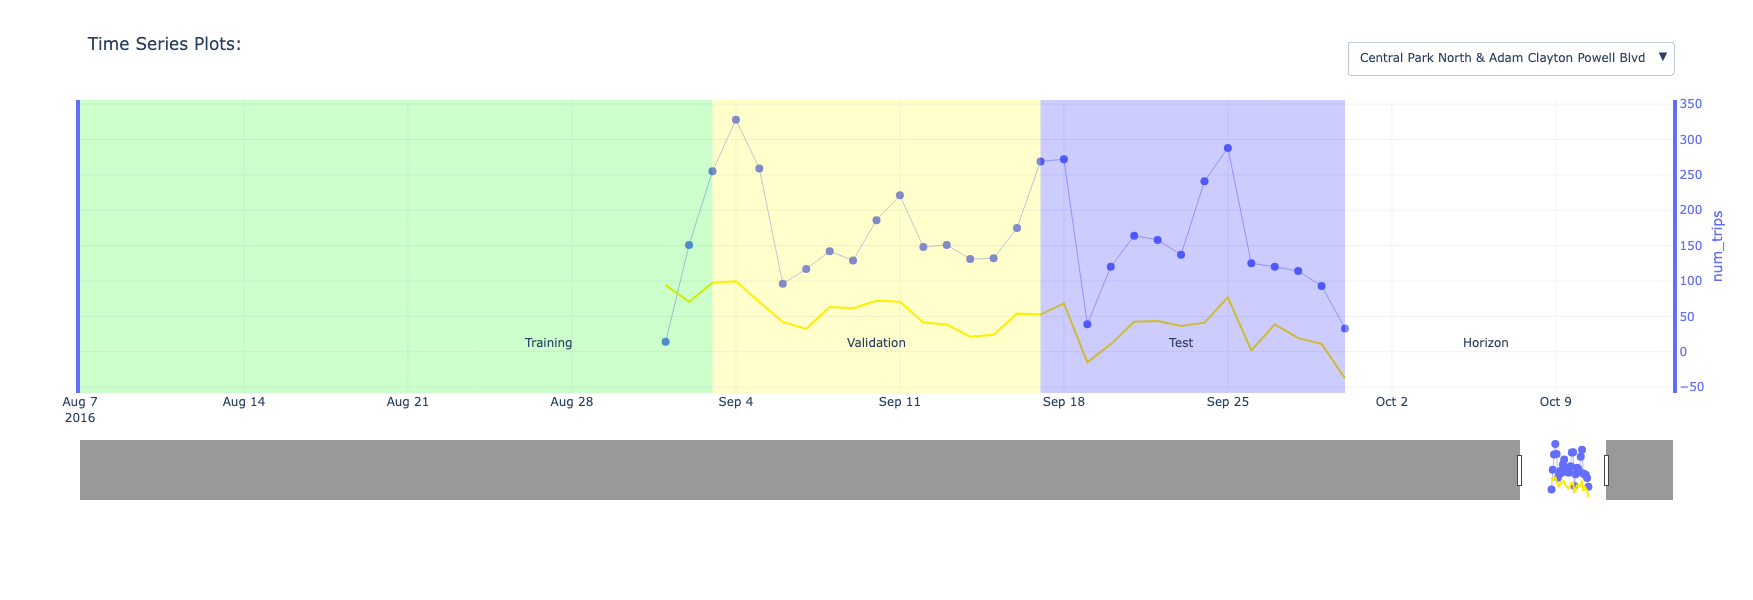

In [20]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex1[pred_ex1[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


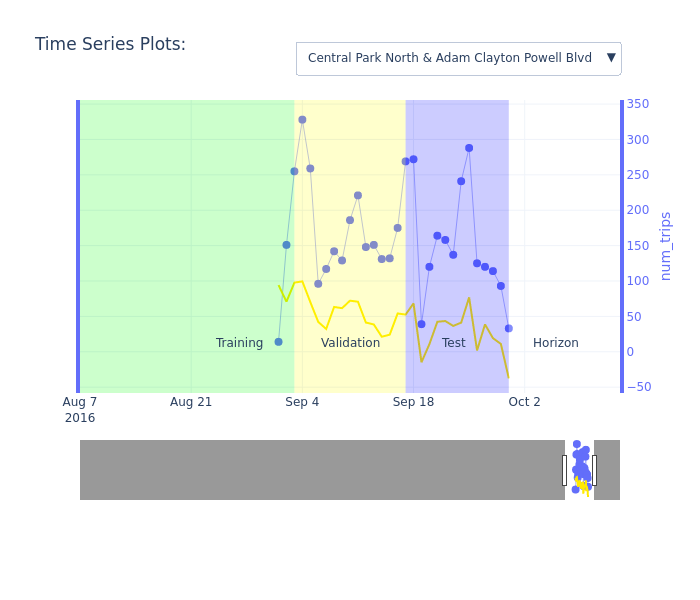

In [21]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Example 2: Linear Regression + Lags

- Prediction - What is demand today based on
    - Covariates
    - Using Time Features: Week, Month, Year, Day, ...
    - Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year

Regression methods don't know about time/date based data types.  To get started, lets first decompose the `TIME_COLUMN` into parts like year, month, day, day of week and model with a linear regression to find the optimal weights of these components.

In [22]:
EX2_CTE = f"""
WITH EX2_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)},
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
        # LAGs
        LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
        LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
        LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
        LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
        LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [23]:
BQ_MODEL = f"{BQ_TABLE}_regression_ex2"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX2_CTE}
    SELECT
        * EXCEPT({SPLIT_COLUMN}),
        CASE
            WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX2_CTE
    WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 14.73


In [24]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_regression_ex2


In [25]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input       weight  \
0   start_station_name          NaN   
1     avg_tripduration    -0.000004   
2       pct_subscriber  -112.556024   
3         ratio_gender     0.526508   
4             capacity    -0.158418   
5                 Year     3.808498   
6                Month    82.894224   
7         Day_of_Month     2.798301   
8          Day_of_Year    -2.744315   
9          Day_of_Week     2.583064   
10             Weekend     2.897590   
11            lag_1day     0.373010   
12           lag_1week     0.204316   
13          lag_1month     0.156924   
14        lag_1quarter    -0.002192   
15           lag_1year     0.101236   
16       __INTERCEPT__ -7845.915884   

                                     category_weights  
0   [{'category': 'Grand Army Plaza & Central Park...  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9                                                  []  
10                                                 []  
11                                                 []  
12                                                 []  
13                                                 []  
14                                                 []  
15                                                 []  
16                                                 []

In [26]:
weights['category_weights'].iloc[0]

array([{'category': 'Grand Army Plaza & Central Park S', 'weight': 193.61592072713566},
       {'category': 'Central Park S & 6 Ave', 'weight': 174.2153200259925},
       {'category': 'Central Park W & W 96 St', 'weight': 162.6759330855202},
       {'category': 'Central Park West & W 68 St', 'weight': 172.4666279772946},
       {'category': 'Central Park West & W 72 St', 'weight': 170.85931865215903},
       {'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': 116.64520714187917},
       {'category': 'Central Park West & W 100 St', 'weight': 129.38524862230818},
       {'category': 'Central Park West & W 102 St', 'weight': 144.97339473041373},
       {'category': 'W 82 St & Central Park West', 'weight': 169.0589988141059},
       {'category': 'Central Park West & W 76 St', 'weight': 147.1814247801297},
       {'category': 'W 106 St & Central Park West', 'weight': 148.49081822479002},
       {'category': 'Central Park West & W 85 St', 'weight': 175.34068444983606}],
 

### Prediction with Lags

It is tricky. In using the 'TEST' split for predictions, each day has the actual data for lags.  In a real forecasting horizon you will not know these values.  For this reason you can only fully predict the first day of the horizon with a one step model like this one. To predict further out you need to recursively feed each forecast back into the same model as a lag for the next step.  This does accumulate errors though.  An alternative to this try a multi-step moel - see Example 3.

The example here does a recursive prediction.

In [27]:
test_start = keyDates['test_start'].iloc[0]
test_start.year, test_start.month, test_start.day

(2016, 9, 17)

In [28]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX2_CTE}
SELECT * EXCEPT(lag_1day, lag_1week),
    CASE
        WHEN DATE(year, month, day_of_month)> DATE({test_start.year},{test_start.month},{test_start.day}) THEN NULL
        ELSE lag_1day
    END AS lag_1day,
    CASE
        WHEN DATE(year, month, day_of_month)> DATE_ADD(DATE({test_start.year},{test_start.month},{test_start.day}), INTERVAL 7 DAY) THEN NULL
        ELSE lag_1week
    END AS lag_1week,
    ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN} ORDER BY year, month, day_of_month) as horizon_day
FROM EX2_CTE
WHERE {SPLIT_COLUMN} = 'TEST'
ORDER BY {SERIES_COLUMN}, year, month, day_of_month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 1.889


Recursively predict the values for the TEST Data and fill in lags (14 day horizon impact lags for day and week):

**THERE MUST BE A BETTER WAY TO DO THE FOLLOWING**
- I tried Recursive CTE but need to reference the base twice (1Day and 1Week) which fails

In [29]:
# PREDICTIONS FOR FIRST DAY OF HORIZON
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_RECURSIVE'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(2, FORECAST_HORIZON_LENGTH + 1):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        WITH
            TODAY AS (
                SELECT * EXCEPT(lag_1day, lag_1week)
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day}
            ),
            LAG_DAY AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1day 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-1} 
            ),
            LAG_WEEK AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1week 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-7} 
            ),
            CURRENT_DAY AS (
                SELECT * FROM
                    TODAY
                    JOIN LAG_DAY USING ({SERIES_COLUMN})
                    LEFT OUTER JOIN LAG_WEEK USING ({SERIES_COLUMN})
            )
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            (SELECT * FROM CURRENT_DAY)
        )
    """
    job = bq.query(query = query)
    job.result()
    

### Evaluation Metrics

The evaluation result show three ways of looking at the test data range:
- `TEST - LEAKED` For days of the test horizon past day 1 the lag values are leaked from known data which likely over estimates the models performance
- `TEST - TRUNCATED` For days of the test horizon past day 1 the lag values remain null if they are from the test horizon
- `TEST - RECURSIVE` For days of the test horizon past day 1 the lag values are recursively retrieved from prior test days predictions.

In [30]:
query = f"""
{EX2_CTE}
# uses recursive predictions to get lags for next step in horizon
SELECT 'TEST - RECURSIVE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
# Truncated does not have lags filled in out of range
SELECT 'TEST - TRUNCATED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
# wrong has lags filled in from actual data but not practical for measuring forecasting horizon - leakage
SELECT 'TEST - LEAKED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'TRAIN'))
ORDER BY SPLIT
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  \
0     TEST - LEAKED            40.273917         3028.863324   
1  TEST - RECURSIVE            54.878861         5028.164003   
2  TEST - TRUNCATED            44.418303         4110.840003   
3             TRAIN            31.801719         1979.129924   
4          VALIDATE            36.466735         2266.429397   

   mean_squared_log_error  median_absolute_error  r2_score  explained_variance  
0                0.427976              30.090233  0.702811            0.743773  
1                0.866554              47.093309  0.506642            0.709073  
2                0.221273              30.064767  0.596649            0.687350  
3                0.337627              22.654569  0.737139            0.737139  
4                0.218244              30.038604  0.800050            0.856786

In [31]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex2 = bq.query(query = query).to_dataframe()
customMetrics_ex2

start_station_name      MAPE         MAE  \
0   Central Park North & Adam Clayton Powell Blvd  0.796796  116.716748   
1                          Central Park S & 6 Ave  0.485462  123.388003   
2                        Central Park W & W 96 St  0.513683   42.242618   
3                    Central Park West & W 100 St  1.384494   40.480029   
4                    Central Park West & W 102 St  1.180696   47.084230   
5                     Central Park West & W 68 St  0.304939   48.519376   
6                     Central Park West & W 72 St  0.315183   47.336109   
7                     Central Park West & W 76 St  0.336029   34.557842   
8                     Central Park West & W 85 St  0.610587   39.473588   
9               Grand Army Plaza & Central Park S  0.363472   45.897863   
10                   W 106 St & Central Park West  0.531344   33.308040   
11                    W 82 St & Central Park West  0.324145   30.658987   

        pMAE           MSE        RMSE     pRMSE  
0   0.751972  16443.995590  128.234144  0.826175  
1   0.378077  19271.411276  138.821509  0.425367  
2   0.422125   2129.240144   46.143690  0.461108  
3   1.021118   2076.584451   45.569556  1.149502  
4   0.929731   2522.609294   50.225584  0.991760  
5   0.320260   3341.829269   57.808557  0.381575  
6   0.267552   3290.463832   57.362565  0.324223  
7   0.315597   1488.897300   38.586232  0.352386  
8   0.313994   2368.107039   48.663200  0.387094  
9   0.211062   2754.326711   52.481680  0.241338  
10  0.498730   1496.446813   38.683935  0.579225  
11  0.332218   1537.489441   39.210833  0.424885

In [32]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex2 = bq.query(query = query).to_dataframe()
customMetrics_ex2

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.598131  54.878861  0.409755  5028.164003  70.909548  0.529449

In [33]:
query = f"""
{EX2_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
    UNION ALL
    SELECT * EXCEPT(horizon_day, predicted_{TARGET_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE {SPLIT_COLUMN} = 'TEST' 
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex2 = bq.query(query = query).to_dataframe()

In [34]:
pred_ex2

start_station_name   starttime   predicted
0     Grand Army Plaza & Central Park S  2013-07-01  119.579122
1                Central Park S & 6 Ave  2013-07-01   97.730875
2     Grand Army Plaza & Central Park S  2013-07-02  116.996273
3                Central Park S & 6 Ave  2013-07-02  118.049604
4     Grand Army Plaza & Central Park S  2013-07-03  127.778683
...                                 ...         ...         ...
4377           Central Park W & W 96 St  2016-09-30   69.159682
4378        Central Park West & W 76 St  2016-09-30   72.370025
4379        W 82 St & Central Park West  2016-09-30   66.551977
4380        Central Park West & W 68 St  2016-09-30   95.772102
4381             Central Park S & 6 Ave  2016-09-30  297.449253

[4382 rows x 3 columns]

In [35]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex2[pred_ex2[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

In [36]:
print('A Snapshot of the interactive plot:')
fig.show('png')

A Snapshot of the interactive plot:


---
## Example 3: Multi-step Linear Regression + Lags + Leads

- Multi-step Prediction - What is demand today (Example 2) based on
    - Covariates
    - Using Time Features: Week, Month, Year, Day, ...
    - Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year
    - Using Leads for each horizon day as targets for Multi-step models

This is like Example 2 extended to build separate model to predict each individual day on the horizon. **NOTE** Step 0 Model here is the same as Example 2 above

In [72]:
def make_model(LEAD):
    EX3_CTE = f"""
    WITH EX3_CTE AS (
        SELECT
            LEAD({TARGET_COLUMN}, {LEAD}) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) as {TARGET_COLUMN},
            {SERIES_COLUMN},
            {SPLIT_COLUMN},
            {', '.join(COVARIATE_COLUMNS)},

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    )
    """
    BQ_MODEL = f"{BQ_TABLE}_regression_ex3_step_{LEAD}"
    query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
        OPTIONS (
            model_type = 'LINEAR_REG',
            input_label_cols = ['{TARGET_COLUMN}'],
            data_split_col = 'custom_splits',
            data_split_method = 'CUSTOM'
        ) AS
        {EX3_CTE}
        SELECT
            * EXCEPT({SPLIT_COLUMN}),
            CASE
                WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
                ELSE TRUE
            END AS custom_splits
        FROM EX3_CTE
        WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
            AND {TARGET_COLUMN} is not NUll
    """ 
    return BQ_MODEL, query

In [73]:
models = []
queries = []
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for lead in range(horizon_length):
    model, query = make_model(lead)
    queries.append(query)
    models.append(model)
models

['forecasting-data_prepped_regression_ex3_step_0',
 'forecasting-data_prepped_regression_ex3_step_1',
 'forecasting-data_prepped_regression_ex3_step_2',
 'forecasting-data_prepped_regression_ex3_step_3',
 'forecasting-data_prepped_regression_ex3_step_4',
 'forecasting-data_prepped_regression_ex3_step_5',
 'forecasting-data_prepped_regression_ex3_step_6',
 'forecasting-data_prepped_regression_ex3_step_7',
 'forecasting-data_prepped_regression_ex3_step_8',
 'forecasting-data_prepped_regression_ex3_step_9',
 'forecasting-data_prepped_regression_ex3_step_10',
 'forecasting-data_prepped_regression_ex3_step_11',
 'forecasting-data_prepped_regression_ex3_step_12',
 'forecasting-data_prepped_regression_ex3_step_13']

In [74]:
jobs = []
for query in queries:
    jobs.append(bq.query(query = query))
    
while not all([job.done() for job in jobs]):
    print('waiting on all jobs to finish ... sleeping for 5s')
    sleep(5)
for j, job in enumerate(jobs):
    print('Completed with Errors = ', job.error_result, 'for ', queries[j].splitlines()[1])

waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_regression_ex3_step_0`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_regression_ex3_step_1`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_regression_ex3_step_2`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_regression_ex3_step_3`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-data_prepped_regression_ex3_step_4`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-3

In [75]:
print(f'Direct link to the models in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{models[-1]}')

Direct link to the models in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_regression_ex3_step_13


In [76]:
for m, model in enumerate(models):
    if m == 0:
        query = f"""
            SELECT * FROM
            (SELECT processed_input, weight as step_{int(model.split('_')[-1])}_weight FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{model}`))
        """
    else:
        query += f"""
            JOIN
            (SELECT processed_input, weight as step_{int(model.split('_')[-1])}_weight FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{model}`))
            USING(processed_input)
        """
#print(query)

In [77]:
weights = bq.query(query = query).to_dataframe()
weights

processed_input  step_0_weight  step_1_weight  step_2_weight  \
0   start_station_name            NaN            NaN            NaN   
1     avg_tripduration      -0.000004      -0.001529      -0.000240   
2       pct_subscriber    -112.556024     -63.747254     -45.708767   
3         ratio_gender       0.526508      -0.827975      -1.985354   
4             capacity      -0.005121       0.338245       0.008481   
5                 Year       3.808498      10.862840      14.599189   
6                Month      82.894224     323.282002     330.643108   
7         Day_of_Month       2.798301      10.397420      10.607832   
8          Day_of_Year      -2.744315     -10.602137     -10.810248   
9          Day_of_Week       2.583064      10.543826       8.841758   
10             Weekend       2.897590     -12.357537     -46.015079   
11            lag_1day       0.373010       0.273956       0.256456   
12           lag_1week       0.204316       0.224927       0.192397   
13          lag_1month       0.156924       0.138530       0.136814   
14        lag_1quarter      -0.002192       0.018116      -0.032166   
15           lag_1year       0.101236       0.183850       0.220986   
16       __INTERCEPT__   -7820.239944  -22452.291605  -29845.243079   

    step_3_weight  step_4_weight  step_5_weight  step_6_weight  step_7_weight  \
0             NaN            NaN            NaN            NaN            NaN   
1       -0.000363      -0.000179      -0.000033       0.000594       0.000769   
2      -17.190604       4.926717      -8.331333      -7.015648      -9.638912   
3       -2.874165      -3.464240      -2.491918      -1.007659      -0.063160   
4       -1.226437      -0.938149      -1.710801      -1.554635      -1.613988   
5       18.343395      19.589048      16.419002      14.927489      16.069524   
6      361.789919     472.319432     425.531059     438.269912     593.757036   
7       11.582253      15.270208      13.685587      14.079465      19.352808   
8      -11.803787     -15.441040     -13.934948     -14.378899     -19.512428   
9        4.078114       0.614526      -2.596018      -4.313699       1.916391   
10     -45.880829     -40.929767     -39.323223      -8.768284      18.015102   
11       0.202976       0.229325       0.349344       0.375096       0.238462   
12       0.211352       0.197520       0.186563       0.218377       0.297940   
13       0.150099       0.158745       0.119295       0.152080       0.210182   
14      -0.084325      -0.079767      -0.055479      -0.068899      -0.047103   
15       0.248274       0.219855       0.161897       0.135476       0.150111   
16  -37651.093358  -40296.950133  -33965.336970  -30745.157702  -33325.899525   

    step_8_weight  step_9_weight  step_10_weight  step_11_weight  \
0             NaN            NaN             NaN             NaN   
1        0.000065       0.000645        0.000765        0.000402   
2       -8.049128      -6.029800       14.627017       18.203095   
3       -1.374541      -2.774498       -3.865581       -3.616449   
4       -1.140872      -0.767565       -2.369241       -0.234193   
5       18.387489      20.626299       22.977961       23.426270   
6      662.544316     616.293087      629.314820      615.064430   
7       21.550041      19.871340       20.379016       19.997976   
8      -21.767515     -20.225376      -20.640729      -20.170773   
9        9.975876       8.295876        3.501152        0.476416   
10      -5.801604     -39.718489      -40.080551      -36.127263   
11       0.200262       0.228701        0.200873        0.236413   
12       0.286974       0.221359        0.205466        0.191815   
13       0.169407       0.126884        0.155796        0.134700   
14      -0.008907      -0.019902       -0.059316       -0.065181   
15       0.215110       0.258536        0.277172        0.263843   
16  -38091.627902  -42625.163667   -47529.558784   -48000.906639   

    step_12_weight  step_13_weight  
0      

### Prediction with Multi-Step Model

There is a separate model for predicting each of the time steps ahead up to the width of the horizon: test horizon + forecast horizon.

Using the input data from just before the test region as inputs, each model yields a prediction for a test day.

In [78]:
BQ_MODEL = f"{BQ_TABLE}_regression_ex3"

In [79]:
EX3_CTE = f"""
WITH
    EX3_CTE AS (
        SELECT
            {TARGET_COLUMN},
            {SERIES_COLUMN},
            {SPLIT_COLUMN},
            {', '.join(COVARIATE_COLUMNS)},

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year,
            
            # number days
            ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN}, {SPLIT_COLUMN} ORDER BY {TIME_COLUMN}) as horizon_day

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`  
    )
"""

In [80]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX3_CTE}
SELECT * FROM
(SELECT * EXCEPT({SPLIT_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year) FROM EX3_CTE WHERE {SPLIT_COLUMN} = 'TEST')
LEFT OUTER JOIN
(SELECT {SERIES_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year FROM EX3_CTE WHERE {SPLIT_COLUMN} = 'TEST' and horizon_day = 1)
USING ({SERIES_COLUMN})
ORDER BY {SERIES_COLUMN}, Year, Month, Day_of_Month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 2.049


Directly predict each day of the horizon with the corresponding model from the multi-step model:

In [81]:
models

['forecasting-data_prepped_regression_ex3_step_0',
 'forecasting-data_prepped_regression_ex3_step_1',
 'forecasting-data_prepped_regression_ex3_step_2',
 'forecasting-data_prepped_regression_ex3_step_3',
 'forecasting-data_prepped_regression_ex3_step_4',
 'forecasting-data_prepped_regression_ex3_step_5',
 'forecasting-data_prepped_regression_ex3_step_6',
 'forecasting-data_prepped_regression_ex3_step_7',
 'forecasting-data_prepped_regression_ex3_step_8',
 'forecasting-data_prepped_regression_ex3_step_9',
 'forecasting-data_prepped_regression_ex3_step_10',
 'forecasting-data_prepped_regression_ex3_step_11',
 'forecasting-data_prepped_regression_ex3_step_12',
 'forecasting-data_prepped_regression_ex3_step_13']

In [82]:
# PREDICTIONS FOR FIRST DAY OF HORIZON - Uses Example 2 Above
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[0]}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_DIRECT'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON (1) TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(1, FORECAST_HORIZON_LENGTH):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[day]}`,
            (
                SELECT *
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day+1}
            )
        )
    """
    job = bq.query(query = query)
    job.result()

In [83]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex3 = bq.query(query = query).to_dataframe()
customMetrics_ex3

start_station_name      MAPE         MAE  \
0   Central Park North & Adam Clayton Powell Blvd  1.217737  100.978016   
1                          Central Park S & 6 Ave  0.583002  102.026172   
2                        Central Park W & W 96 St  0.529660   33.708491   
3                    Central Park West & W 100 St  0.634559   22.705309   
4                    Central Park West & W 102 St  0.559307   28.357379   
5                     Central Park West & W 68 St  0.368862   47.806994   
6                     Central Park West & W 72 St  0.552996   47.311164   
7                     Central Park West & W 76 St  0.324297   32.241219   
8                     Central Park West & W 85 St  0.761186   48.908070   
9               Grand Army Plaza & Central Park S  0.636706   66.405967   
10                   W 106 St & Central Park West  0.279382   17.519917   
11                    W 82 St & Central Park West  0.412725   44.723669   

        pMAE           MSE        RMSE     pRMSE  
0   0.650572  13875.314940  117.793527  0.758909  
1   0.312621  16655.426918  129.055906  0.395444  
2   0.336844   2077.000926   45.574126  0.455416  
3   0.572747   1064.741473   32.630377  0.823109  
4   0.559948   1479.252575   38.461053  0.759457  
5   0.315558   3318.507302   57.606487  0.380241  
6   0.267411   3398.489346   58.296564  0.329502  
7   0.294440   2013.038859   44.866902  0.409743  
8   0.389041   3550.670485   59.587503  0.473991  
9   0.305369   6922.865987   83.203762  0.382614  
10  0.262330    642.066661   25.339034  0.379408  
11  0.484622   3631.184532   60.259311  0.652965

In [84]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex3 = bq.query(query = query).to_dataframe()
customMetrics_ex3

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.563068  49.318362  0.368238  4941.030134  70.292461  0.524842

In [85]:
query = f"""
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
ORDER BY Year, Month, Day_of_Month
"""
pred_ex3 = bq.query(query = query).to_dataframe()

In [86]:
pred_ex3

start_station_name   starttime   predicted
0                         Central Park W & W 96 St  2016-09-17  118.729581
1                     Central Park West & W 100 St  2016-09-17   52.681132
2                     Central Park West & W 102 St  2016-09-17   55.911870
3                      Central Park West & W 76 St  2016-09-17  139.922917
4    Central Park North & Adam Clayton Powell Blvd  2016-09-17  127.447288
..                                             ...         ...         ...
154                       Central Park W & W 96 St  2016-09-30   81.758623
155                    Central Park West & W 76 St  2016-09-30   85.462250
156                    W 82 St & Central Park West  2016-09-30   34.495998
157                    Central Park West & W 68 St  2016-09-30  116.581294
158                         Central Park S & 6 Ave  2016-09-30  307.624961

[159 rows x 3 columns]

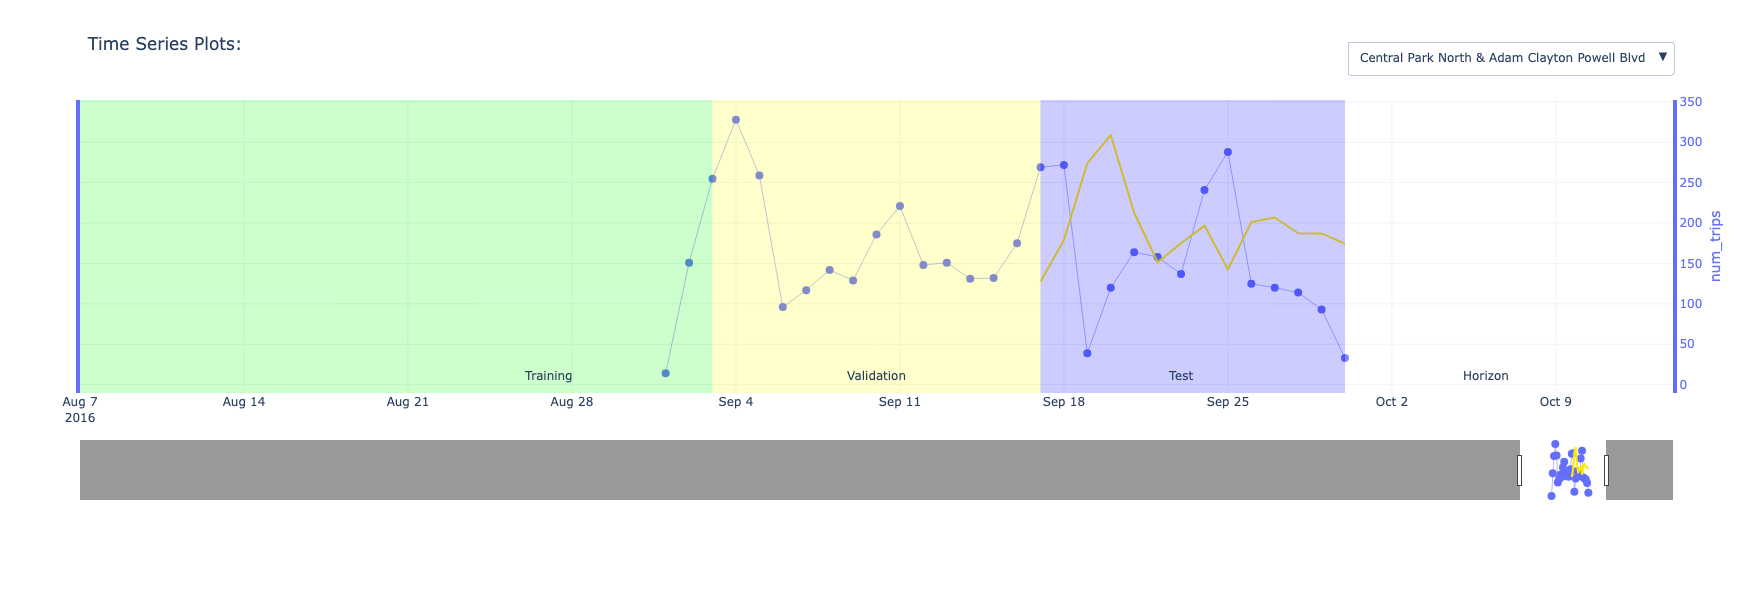

In [87]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex3[pred_ex3[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex3[pred_ex3[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex3[pred_ex3[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

In [88]:
print('A Snapshot of the interactive plot:')
fig.show('png')

A Snapshot of the interactive plot:


---
## Example 4: Multi-step Boosted Tree Regression + Lags + Leads

- Multi-step Prediction - What is demand today (Example 2) based on
    - Covariates
    - Using Time Features: Week, Month, Year, Day, ...
    - Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year
    - Using Leads for each horizon day as targets for Multi-step models

This is like Example 3 with gradient boosted trees rather than linear regression.  For non-linear patterns in the data this method should provide more accurate results.

In [93]:
def make_model(LEAD):
    EX4_CTE = f"""
    WITH EX4_CTE AS (
        SELECT
            LEAD({TARGET_COLUMN}, {LEAD}) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) as {TARGET_COLUMN},
            {SERIES_COLUMN},
            {SPLIT_COLUMN},
            {', '.join(COVARIATE_COLUMNS)},

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    )
    """
    BQ_MODEL = f"{BQ_TABLE}_regression_ex4_step_{LEAD}"
    query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
        OPTIONS (
            model_type = 'BOOSTED_TREE_REGRESSOR',
            input_label_cols = ['{TARGET_COLUMN}'],
            data_split_col = 'custom_splits',
            data_split_method = 'CUSTOM',
            booster_type = 'GBTREE',
            num_parallel_tree = 1,
            max_iterations = 30,
            early_stop = TRUE,
            min_rel_progress = 0.01,
            tree_method = 'HIST',
            subsample = 0.85
        ) AS
        {EX4_CTE}
        SELECT
            * EXCEPT({SPLIT_COLUMN}),
            CASE
                WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
                ELSE TRUE
            END AS custom_splits
        FROM EX4_CTE
        WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
            AND {TARGET_COLUMN} is not NUll
    """ 
    return BQ_MODEL, query

In [94]:
models = []
queries = []
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for lead in range(horizon_length):
    model, query = make_model(lead)
    queries.append(query)
    models.append(model)
models

['forecasting-data_prepped_regression_ex4_step_0',
 'forecasting-data_prepped_regression_ex4_step_1',
 'forecasting-data_prepped_regression_ex4_step_2',
 'forecasting-data_prepped_regression_ex4_step_3',
 'forecasting-data_prepped_regression_ex4_step_4',
 'forecasting-data_prepped_regression_ex4_step_5',
 'forecasting-data_prepped_regression_ex4_step_6',
 'forecasting-data_prepped_regression_ex4_step_7',
 'forecasting-data_prepped_regression_ex4_step_8',
 'forecasting-data_prepped_regression_ex4_step_9',
 'forecasting-data_prepped_regression_ex4_step_10',
 'forecasting-data_prepped_regression_ex4_step_11',
 'forecasting-data_prepped_regression_ex4_step_12',
 'forecasting-data_prepped_regression_ex4_step_13']

In [95]:
jobs = []
for query in queries:
    jobs.append(bq.query(query = query))
    
while not all([job.done() for job in jobs]):
    print('waiting on all jobs to finish ... sleeping for 5s')
    sleep(5)
for j, job in enumerate(jobs):
    print('Completed with Errors = ', job.error_result, 'for ', queries[j].splitlines()[1])

waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s


In [96]:
print(f'Direct link to the models in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{models[-1]}')

Direct link to the models in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_regression_ex4_step_13


### Prediction with Multi-Step Model

There is a separate model for predicted each number of steps ahead up to the width of the horizon here: text horizon.

Using the input data from just before the test region as inputs, each model yields a prediction for a test day.

In [97]:
BQ_MODEL = f"{BQ_TABLE}_regression_ex4"

In [98]:
EX4_CTE = f"""
WITH
    EX4_CTE AS (
        SELECT
            {TARGET_COLUMN},
            {SERIES_COLUMN},
            {SPLIT_COLUMN},
            {', '.join(COVARIATE_COLUMNS)},

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year,
            
            # number days
            ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN}, {SPLIT_COLUMN} ORDER BY {TIME_COLUMN}) as horizon_day

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`  
    )
"""

In [99]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX4_CTE}
SELECT * FROM
(SELECT * EXCEPT({SPLIT_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year) FROM EX4_CTE WHERE {SPLIT_COLUMN} = 'TEST')
LEFT OUTER JOIN
(SELECT {SERIES_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year FROM EX4_CTE WHERE {SPLIT_COLUMN} = 'TEST' and horizon_day = 1)
USING ({SERIES_COLUMN})
ORDER BY {SERIES_COLUMN}, Year, Month, Day_of_Month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 2.101


Directly predict each day of the horizon with the corresponding model from the multi-step model:

In [100]:
models

['forecasting-data_prepped_regression_ex4_step_0',
 'forecasting-data_prepped_regression_ex4_step_1',
 'forecasting-data_prepped_regression_ex4_step_2',
 'forecasting-data_prepped_regression_ex4_step_3',
 'forecasting-data_prepped_regression_ex4_step_4',
 'forecasting-data_prepped_regression_ex4_step_5',
 'forecasting-data_prepped_regression_ex4_step_6',
 'forecasting-data_prepped_regression_ex4_step_7',
 'forecasting-data_prepped_regression_ex4_step_8',
 'forecasting-data_prepped_regression_ex4_step_9',
 'forecasting-data_prepped_regression_ex4_step_10',
 'forecasting-data_prepped_regression_ex4_step_11',
 'forecasting-data_prepped_regression_ex4_step_12',
 'forecasting-data_prepped_regression_ex4_step_13']

In [101]:
# PREDICTIONS FOR FIRST DAY OF HORIZON
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[0]}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_DIRECT'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON (1) TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(1, FORECAST_HORIZON_LENGTH):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[day]}`,
            (
                SELECT *
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day+1}
            )
        )
    """
    job = bq.query(query = query)
    job.result()

In [102]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex4 = bq.query(query = query).to_dataframe()
customMetrics_ex4

start_station_name      MAPE         MAE  \
0   Central Park North & Adam Clayton Powell Blvd  0.747369   72.954235   
1                          Central Park S & 6 Ave  0.569431  137.857015   
2                        Central Park W & W 96 St  0.611868   35.405054   
3                    Central Park West & W 100 St  1.609231   31.420627   
4                    Central Park West & W 102 St  0.604413   15.836948   
5                     Central Park West & W 68 St  0.448946   51.471019   
6                     Central Park West & W 72 St  0.653321   61.939833   
7                     Central Park West & W 76 St  0.443821   37.518491   
8                     Central Park West & W 85 St  1.056932   60.237597   
9               Grand Army Plaza & Central Park S  0.407802   59.149582   
10                   W 106 St & Central Park West  0.342100   18.953196   
11                    W 82 St & Central Park West  0.374410   38.935738   

        pMAE           MSE        RMSE     pRMSE  
0   0.470023   7084.682742   84.170557  0.542286  
1   0.422412  23560.653658  153.494800  0.470328  
2   0.353798   1743.840907   41.759321  0.417295  
3   0.792592   1292.172439   35.946800  0.906766  
4   0.312718    400.636703   20.015911  0.395237  
5   0.339743   3411.600668   58.408909  0.385537  
6   0.350095   5266.131102   72.568114  0.410168  
7   0.342635   2022.604054   44.973371  0.410716  
8   0.479163   5513.340025   74.251869  0.590640  
9   0.272000   5784.497684   76.055885  0.349744  
10  0.283791    511.238546   22.610585  0.338554  
11  0.421904   2564.337938   50.639292  0.548723

In [103]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex4 = bq.query(query = query).to_dataframe()
customMetrics_ex4

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.639719  51.325523  0.383224  4896.454727  69.974672  0.522469

In [104]:
query = f"""
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
ORDER BY Year, Month, Day_of_Month
"""
pred_ex4 = bq.query(query = query).to_dataframe()

In [105]:
pred_ex4

start_station_name   starttime   predicted
0                         Central Park W & W 96 St  2016-09-17  108.966118
1                     Central Park West & W 100 St  2016-09-17   78.945488
2                     Central Park West & W 102 St  2016-09-17   70.357689
3                      Central Park West & W 76 St  2016-09-17  154.350250
4    Central Park North & Adam Clayton Powell Blvd  2016-09-17  182.084305
..                                             ...         ...         ...
154                    W 82 St & Central Park West  2016-09-30   54.264366
155                    Central Park West & W 68 St  2016-09-30  131.397415
156                         Central Park S & 6 Ave  2016-09-30  217.415588
157              Grand Army Plaza & Central Park S  2016-09-30  151.258926
158                    Central Park West & W 72 St  2016-09-30  191.314957

[159 rows x 3 columns]

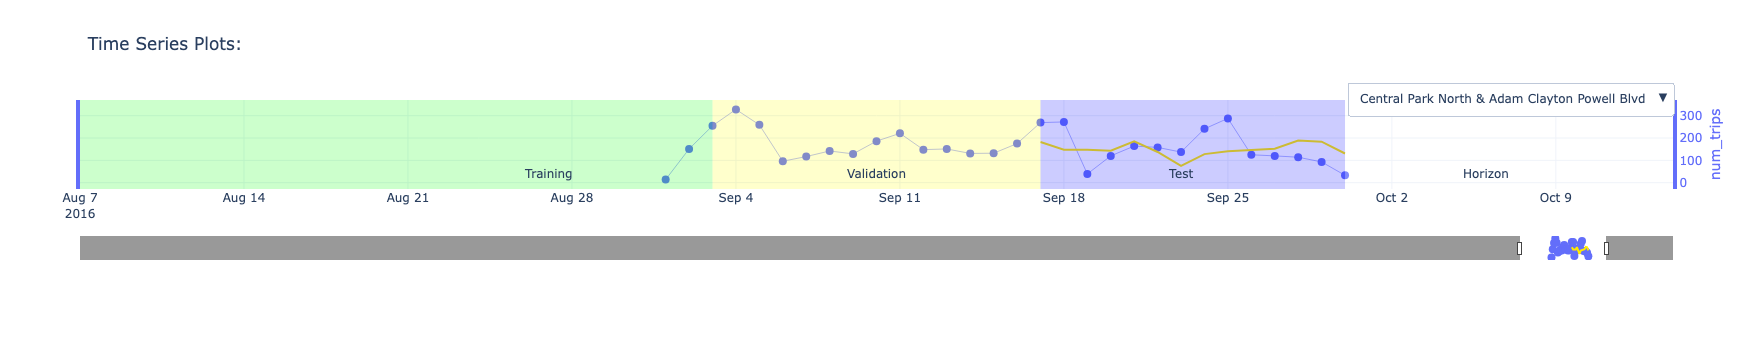

In [106]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex4[pred_ex4[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex4[pred_ex4[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex4[pred_ex4[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


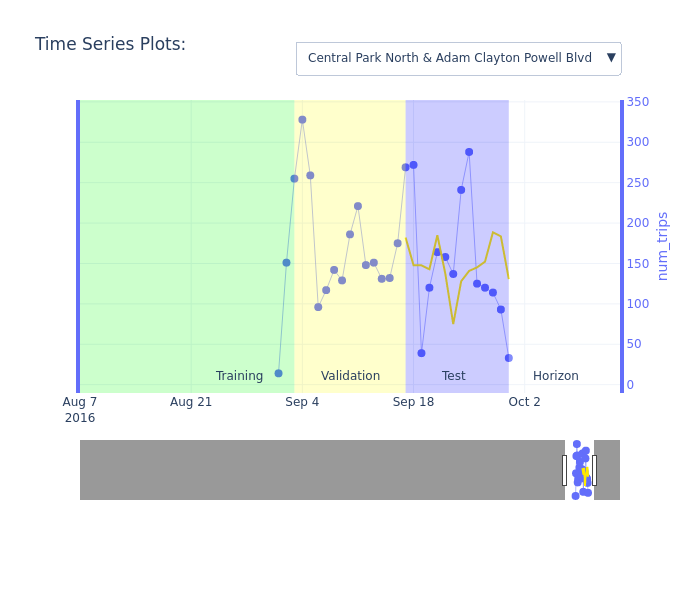

In [107]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Comparison

In [108]:
customMetrics_ex1['example'] = 'Example 1'
customMetrics_ex2['example'] = 'Example 2'
customMetrics_ex3['example'] = 'Example 3'
customMetrics_ex4['example'] = 'Example 4'

combined = pd.concat([customMetrics_ex1, customMetrics_ex2, customMetrics_ex3, customMetrics_ex4], axis = 0, ignore_index = True)
combined.insert(0, 'example', combined.pop('example'))
combined

example      MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  Example 1  0.513595  57.448783  0.428944  6548.842378  80.924918  0.604229
1  Example 2  0.598131  54.878861  0.409755  5028.164003  70.909548  0.529449
2  Example 3  0.563068  49.318362  0.368238  4941.030134  70.292461  0.524842
3  Example 4  0.639719  51.325523  0.383224  4896.454727  69.974672  0.522469

In [109]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex1[pred_ex1[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    name = f'Example 1: {v}',
                    text = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)', 'dash': 'dot'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            fig.add_trace(
                go.Scatter(
                    x = pred_ex2[pred_ex2[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    name = f'Example 2: {v}',
                    text = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)', 'dash': 'dash'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            fig.add_trace(
                go.Scatter(
                    x = pred_ex3[pred_ex3[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex3[pred_ex3[SERIES_COLUMN]==s]['predicted'],
                    name = f'Example 3: {v}',
                    text = pred_ex3[pred_ex3[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)', 'dash': 'longdash'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            fig.add_trace(
                go.Scatter(
                    x = pred_ex4[pred_ex4[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex4[pred_ex4[SERIES_COLUMN]==s]['predicted'],
                    name = f'Example 4: {v}',
                    text = pred_ex4[pred_ex4[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)', 'dash': 'solid'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 4 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

In [110]:
print('A Snapshot of the interactive plot:')
fig.show('png')

A Snapshot of the interactive plot:


---
## Remove Resources

To remove the models created in BigQuery uncomment the `bq.delete_model` statement and run the cell below:

In [16]:
prefixes = [f"{BQ_TABLE}_regression_ex1", f"{BQ_TABLE}_regression_ex2", f"{BQ_TABLE}_regression_ex3", f"{BQ_TABLE}_regression_ex4"]

In [17]:
models = bq.list_models(dataset = f"{BQ_PROJECT}.{BQ_DATASET}")

In [18]:
for model in models:
    if any([model.model_id.startswith(prefix) for prefix in prefixes]): 
        print(f'deleting {model.model_id}')
        bq.delete_model(model)